In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split

###### we use exactly the trend in chapter 2, without making any further adjustment or analysis

### loading dataset

In [2]:
def load_data(path='dataset/owid-covid-data.csv') -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
covid_raw = load_data()
covid_raw.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
covid_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166326 entries, 0 to 166325
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    166326 non-null  object 
 1   continent                                   156370 non-null  object 
 2   location                                    166326 non-null  object 
 3   date                                        166326 non-null  object 
 4   total_cases                                 163293 non-null  float64
 5   new_cases                                   163133 non-null  float64
 6   new_cases_smoothed                          161150 non-null  float64
 7   total_deaths                                145451 non-null  float64
 8   new_deaths                                  145487 non-null  float64
 9   new_deaths_smoothed                         143390 non-null  float64
 

In [ ]:
covid_rf =  covid_raw[['location', 'location', 'date', 'total_cases', 'new_cases', 
                       'total_deaths', 'new_deaths']]

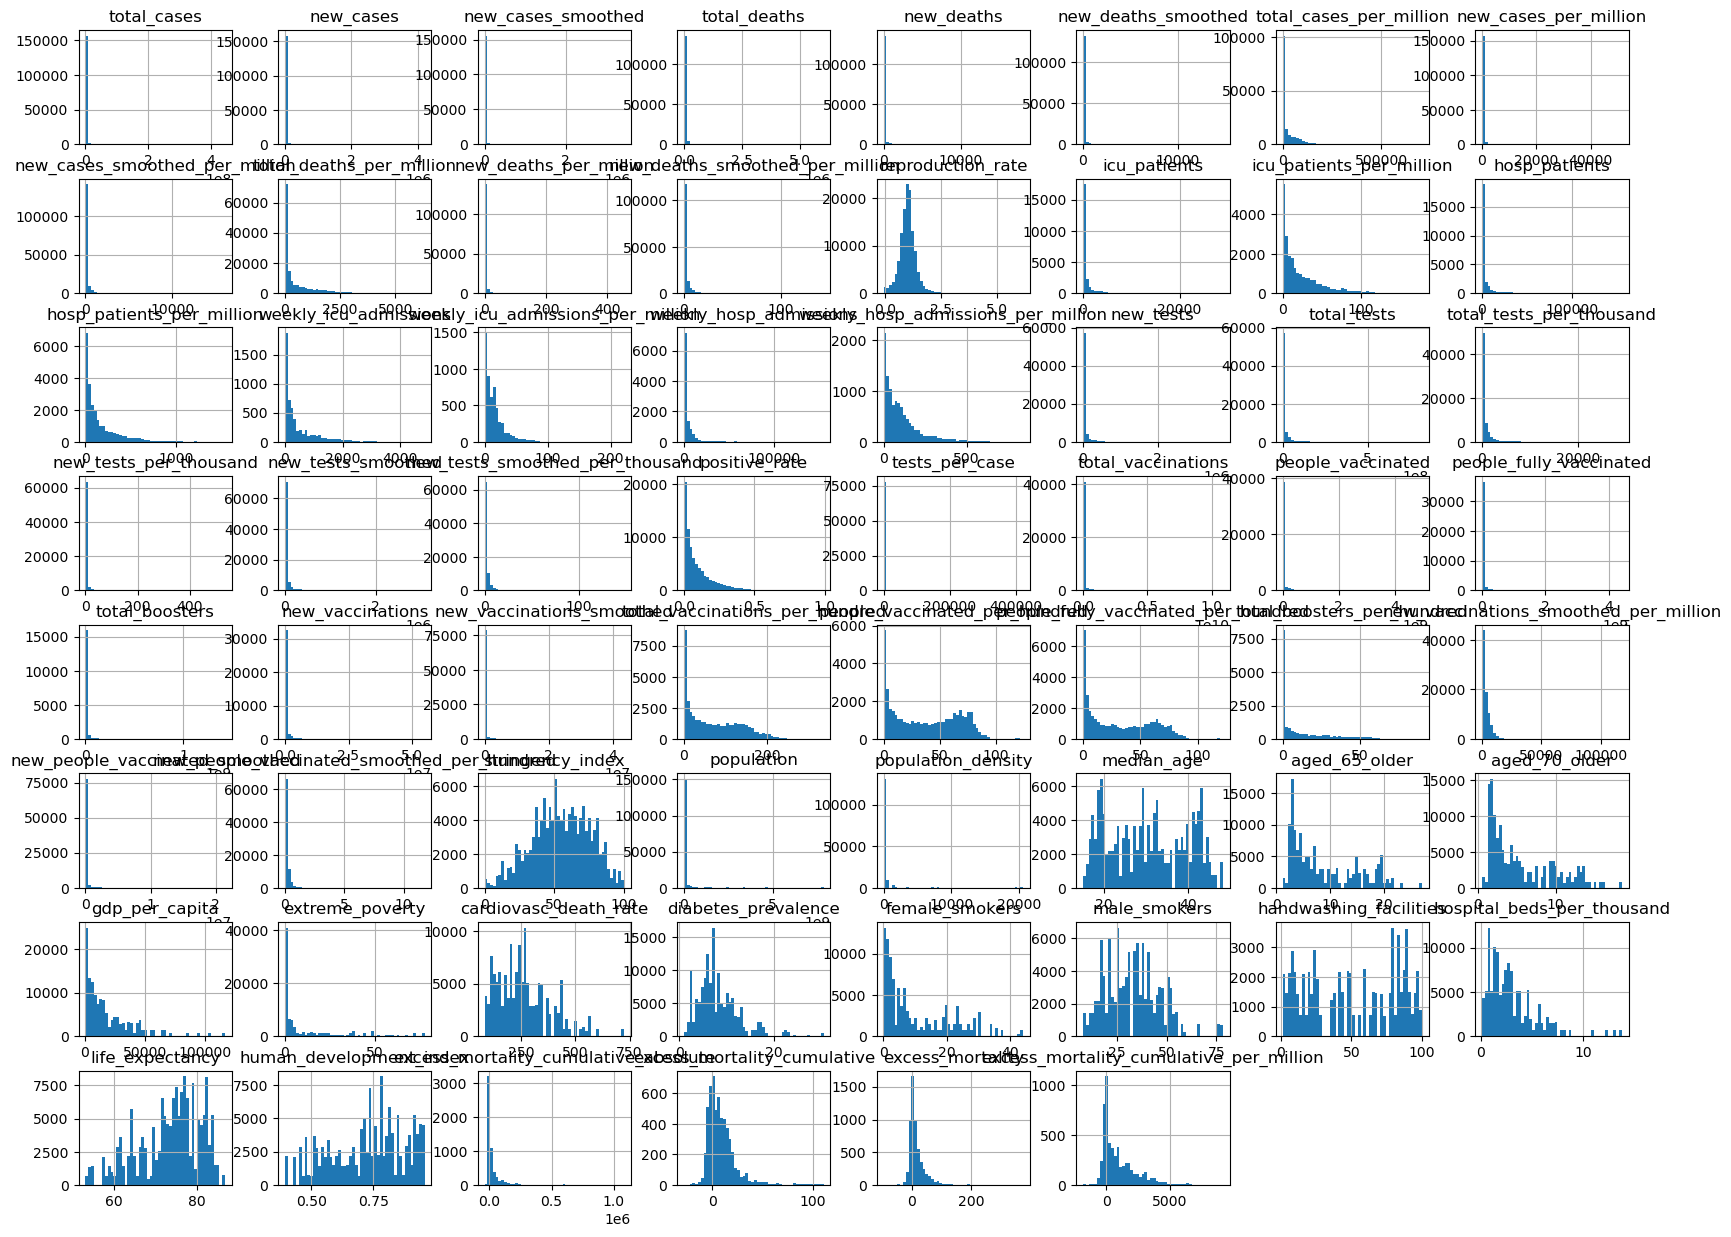

In [5]:
covid_raw.hist(bins=50, figsize=(20, 15))
plt.show()

In [10]:
train_set, test_set = train_test_split(covid_raw, test_size=0.2, random_state=42)

print(len(train_set))
print(len(test_set))

190
48
